In [462]:
import xrspatial
import geopandas as gpd
import rasterio as rio
import numpy as np
import rioxarray as rxr
import xarray as xr
import pandas as pd
import plotly.express as px
from tqdm import tqdm

In [313]:
ds = rxr.open_rasterio('../Arecanut/fcc_3.tif').to_dataset(dim='band')/10000

In [152]:
def get_zonal_raster(stack_norm,boundary_df):
    image = rio.features.rasterize(
        [(g, v) for g, v in zip(boundary_df.geometry,boundary_df.LC)],
        out_shape=stack_norm.rio.shape,
        transform=stack_norm.rio.transform(),
        all_touched=False,fill=np.nan)
    zone_xr = xr.DataArray(image)
    return zone_xr

def get_index_stats_array(indexXarray,zonal_raster):
    index_stats_df=[]
    for i in indexXarray:
        xarray = indexXarray[i]
        zonal_stats_df = xrspatial.zonal.stats(zones=zonal_raster,values=xarray,stats_funcs=["mean"],nodata_values=np.nan)
        # zonal_stats_df["time"] =  np.datetime64(xarray.time.data)
        zonal_stats_df["spectral_index"] = i
        # zonal_stats_df = zonal_stats_df.compute(scheduler='distributed')
        index_stats_df.append(zonal_stats_df)
            # del zonal_stats_df
        # client.restart()
    return pd.concat(index_stats_df)

def procces_index(stats):
    l = []
    for i in stats['spectral_index'].unique():
        stats_si = stats[stats['spectral_index']==i].copy().groupby(["zone"])[["mean"]].mean().rename(columns={'mean':i})
        l.append(stats_si)
    return pd.concat(l,axis=1,ignore_index=True)

In [153]:
sign_lc = gpd.read_file('../Arecanut/signature_loc.geojson').to_crs(32643)

In [210]:
zone  = get_zonal_raster(ds[1],sign_lc)

In [211]:
stats = get_index_stats_array(ds,zone)

In [200]:
stats = procces_index(stats).reset_index()

In [ ]:
lulc = ['Agricultural land',
 'Arecanut',
 'Built-up',
 'Coconut',
 'Crop land',
 'Fallow land',
 'Forest',
 'Mango',
 'Plantation',
 'Wastelands',
 'Water bodies',
 'Wetlands']

sprectral_bands = ['Blue',
 'Green',
 'Red',
 'RE1',
 'RE2',
 'RE3',
 'NIR',
 'RE4',
 'Water vapour',
 'SWIR1',
 'SWIR2',]

In [221]:
cateogories = pd.Series(lulc)

zones = pd.Series([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10., 12., 13., 14.])

cate_df = pd.DataFrame({'LULC':cateogories,'zone':zones})

In [224]:
stats = stats.merge(cate_df,on='zone')

In [229]:
bands = pd.Series(sprectral_bands)

spectral_index = pd.Series([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

bands_df = pd.DataFrame({'bands':bands,'spectral_index':spectral_index})

In [231]:
stats = stats.merge(bands_df,on='spectral_index')

In [236]:
fig = px.line(stats,y='mean',x='bands',color='LULC',height=700,markers=True)
fig.write_html("../Arecanut/spectral_signatures.html")

In [238]:
def bhattacharyya_distance(mean1, cov1, mean2, cov2):
    """Calculate Bhattacharyya distance between two classes."""
    mean_diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    
    # First term
    first_term = 0.125 * np.dot(np.dot(mean_diff.T, np.linalg.inv(cov_mean)), mean_diff)
    
    # Second term (log determinant ratio)
    second_term = 0.5 * np.log(np.linalg.det(cov_mean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    
    return first_term + second_term

def jeffries_matusita_distance(mean1, cov1, mean2, cov2):
    """Calculate Jeffries-Matusita distance between two classes."""
    B = bhattacharyya_distance(mean1, cov1, mean2, cov2)
    JM = 2 * (1 - np.exp(-B))
    return JM

def divergence(mean1, cov1, mean2, cov2):
    """Calculate divergence between two classes."""
    mean_diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    
    # First term: Trace term for divergence
    trace_term = 0.5 * np.trace(np.dot(np.dot((cov1 - cov2), (cov1 - cov2)), np.linalg.inv(cov_mean)))
    
    # Second term: Mahalanobis distance component
    mahalanobis_term = 0.5 * np.dot(np.dot(mean_diff.T, np.linalg.inv(cov_mean)), mean_diff)
    
    return trace_term + mahalanobis_term

def transformed_divergence(mean1, cov1, mean2, cov2):
    """Calculate Transformed Divergence (TD) between two classes."""
    D = divergence(mean1, cov1, mean2, cov2)
    TD = 2000 * (1 - np.exp(-0.5 * D))
    return TD

Jeffries-Matusita Distance: 0.3576602136522944
Transformed Divergence: 200.6840458867618


In [248]:
# Ensure that `zone` has the same dimensions as `ds`
zone_aligned = zone.rename({'dim_0': 'y', 'dim_1': 'x'}).reindex_like(ds)

In [299]:
def mean_covr(ds,cl,zone):
    class_stats = {}
    # Filter out the pixels for the current class
    class_pixels = ds.where(zone == cl, drop=True)

    # Extract band data
    band_data = [class_pixels[band].values.flatten() for band in ds.data_vars]

    # Create a pandas DataFrame with band data for easier manipulation
    df = pd.DataFrame(np.array(band_data).T, columns=ds.data_vars)

    # Calculate mean vector and covariance matrix for this class
    mean_vector = df.mean().values
    covariance_matrix = df.cov().values

    class_stats[cl] = {
        'mean': mean_vector,
        'cov': covariance_matrix
    }
    return class_stats

In [267]:
# Assuming `ds` is your xarray.Dataset
data_var_names = list(ds.data_vars)

In [256]:
from itertools import combinations

In [466]:
band_combinations = list(combinations(data_var_names,3))
class_combinations = list(combinations(np.unique(zone),2))
band_names = list(combinations(sprectral_bands,3))

class_names = list(combinations(lulc,2))

In [410]:
filtered_list = [tup for tup in class_combinations if all(x!=0 for x in tup)]

In [469]:
df = []
for index,i in enumerate(tqdm(band_combinations,desc = 'Bands')):
    # frame = pd.DataFrame(columns = class_names)
    # frame['Band Combintations'] = pd.Series(band_names)
    subset_ds = ds[[i[0],i[1],i[2]]]
    for jindex,j in enumerate(tqdm(filtered_list)):
        frame = pd.DataFrame()
        first = mean_covr(subset_ds,j[0],zone_aligned)
        second = mean_covr(subset_ds,j[1],zone_aligned)
        JM_distance = jeffries_matusita_distance(first[j[0]]['mean'], first[j[0]]['cov'], second[j[1]]['mean'], second[j[1]]['cov'])
        TD_distance = transformed_divergence(first[j[0]]['mean'], first[j[0]]['cov'], second[j[1]]['mean'], second[j[1]]['cov'])
        frame['TD'] = pd.Series(TD_distance)
        frame['JD'] = pd.Series(JM_distance)
        frame['Band Combination'] = pd.Series([band_names[index]])
        frame['Class Combination'] = pd.Series([class_names[jindex]])
        df.append(frame)

 15%|██████▌                                    | 10/66 [00:01<00:07,  7.48it/s]/var/folders/3c/04j8kfh5095g8fp48zx88dbh0000gn/T/ipykernel_35653/2272545187.py:12: RuntimeWarning:

invalid value encountered in sqrt


 30%|█████████████                              | 20/66 [00:02<00:06,  7.56it/s]/var/folders/3c/04j8kfh5095g8fp48zx88dbh0000gn/T/ipykernel_35653/2272545187.py:12: RuntimeWarning:

invalid value encountered in sqrt


 44%|██████████████████▉                        | 29/66 [00:04<00:04,  7.44it/s]/var/folders/3c/04j8kfh5095g8fp48zx88dbh0000gn/T/ipykernel_35653/2272545187.py:12: RuntimeWarning:

invalid value encountered in sqrt


 56%|████████████████████████                   | 37/66 [00:05<00:03,  7.54it/s]/var/folders/3c/04j8kfh5095g8fp48zx88dbh0000gn/T/ipykernel_35653/2272545187.py:12: RuntimeWarning:

invalid value encountered in sqrt


 67%|████████████████████████████▋              | 44/66 [00:06<00:03,  7.33it/s]/var/folders/3c/04j8kfh5095g8fp48zx88dbh0000gn/T/ipykern

In [470]:
final_df = pd.concat(df,ignore_index=True)

In [566]:
arecanut_final_df = final_df[final_df['Class Combination'].apply(lambda x: x[0] == "Arecanut" or x[1] == "Arecanut")].groupby('Band Combination')[['TD','JD']].mean().reset_index()

In [568]:
final_df_g = final_df.groupby('Band Combination')[['TD','JD']].mean().reset_index()

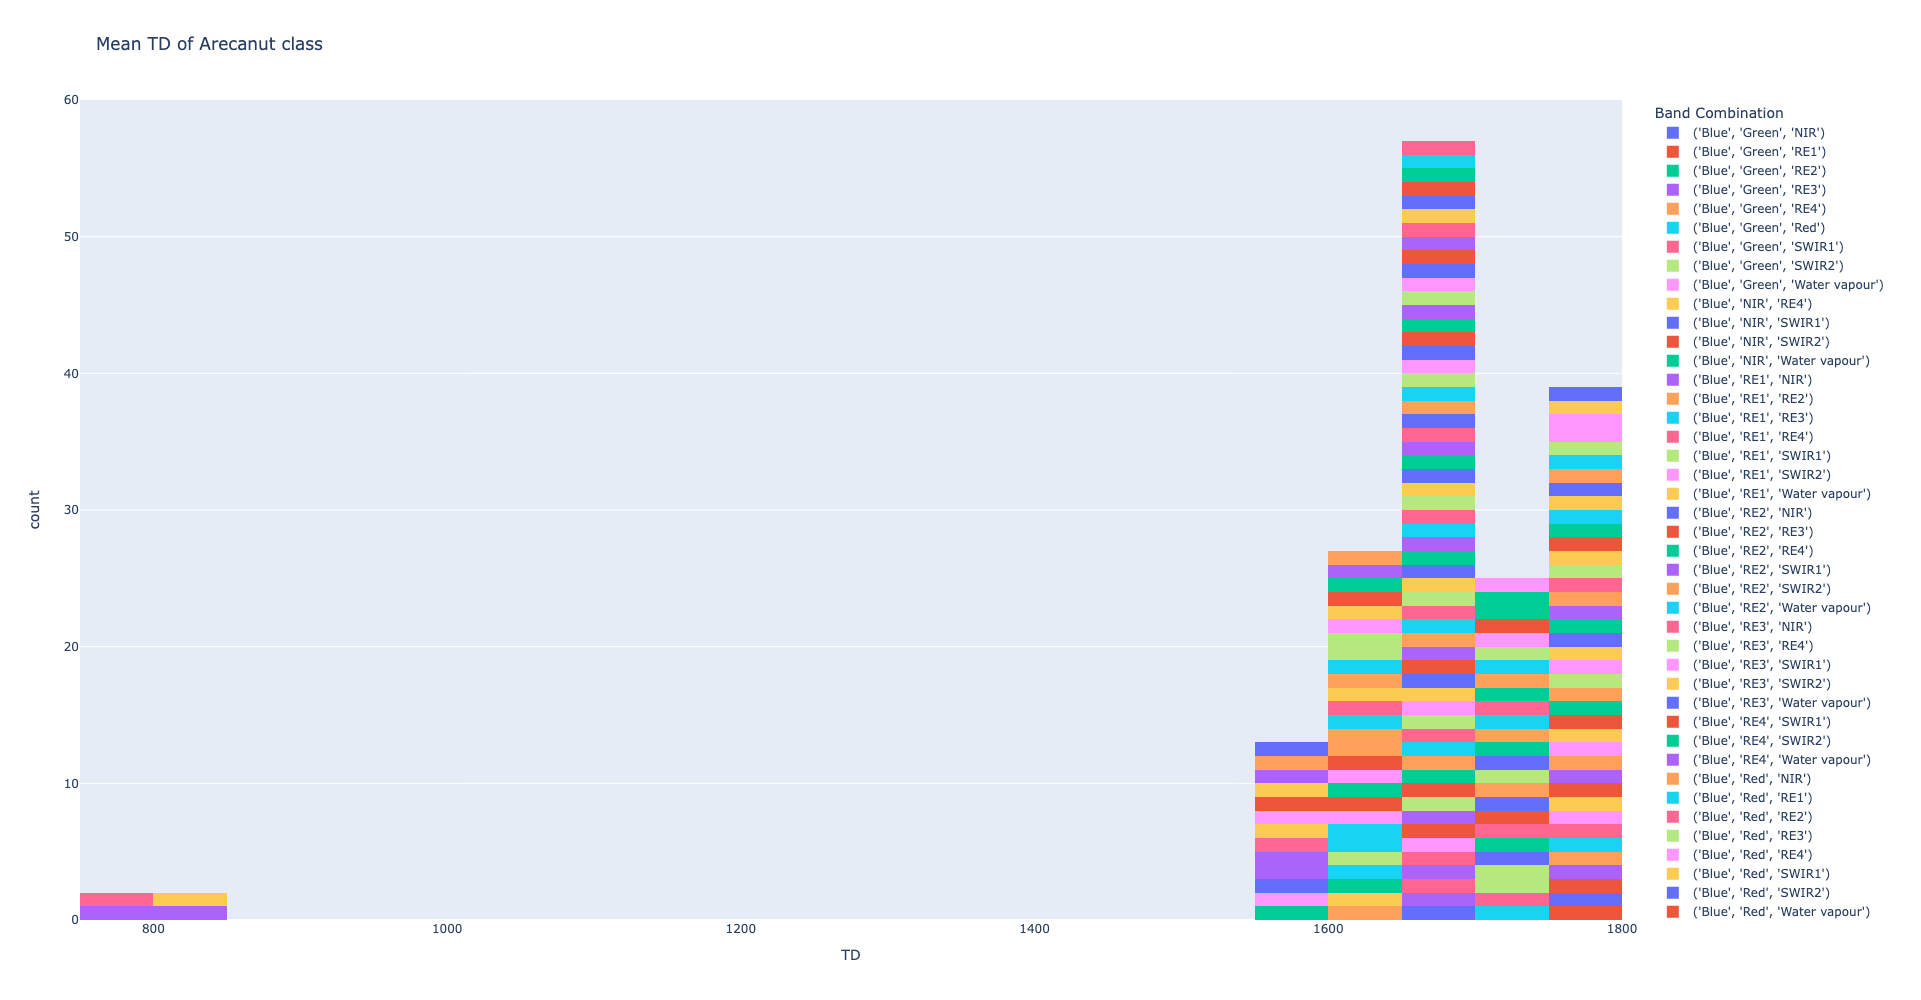

In [574]:
fig = px.histogram(arecanut_final_df,x='TD',color='Band Combination',height=1000,title='Mean TD of Arecanut class')
fig.write_html("../Arecanut/mean_td_arecanut.html")
fig.show()

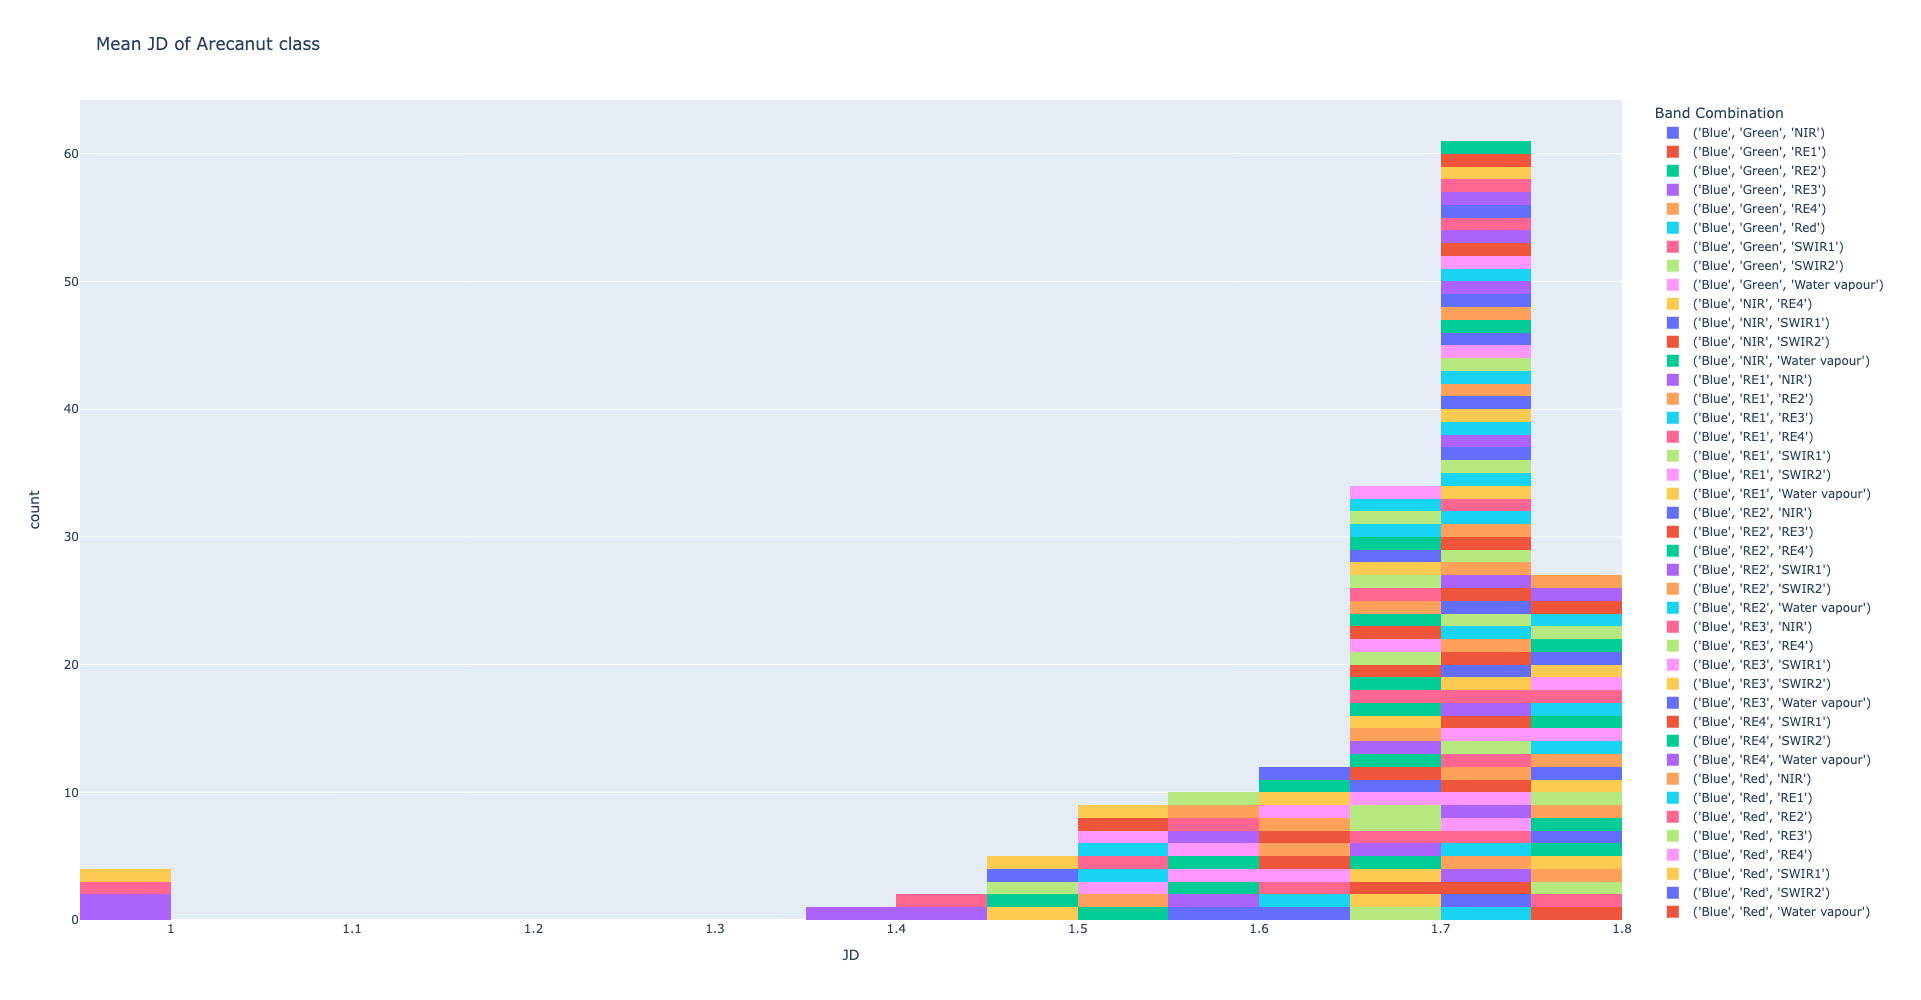

In [575]:
px.histogram(arecanut_final_df,x='JD',color='Band Combination',height=1000,title='Mean JD of Arecanut class')

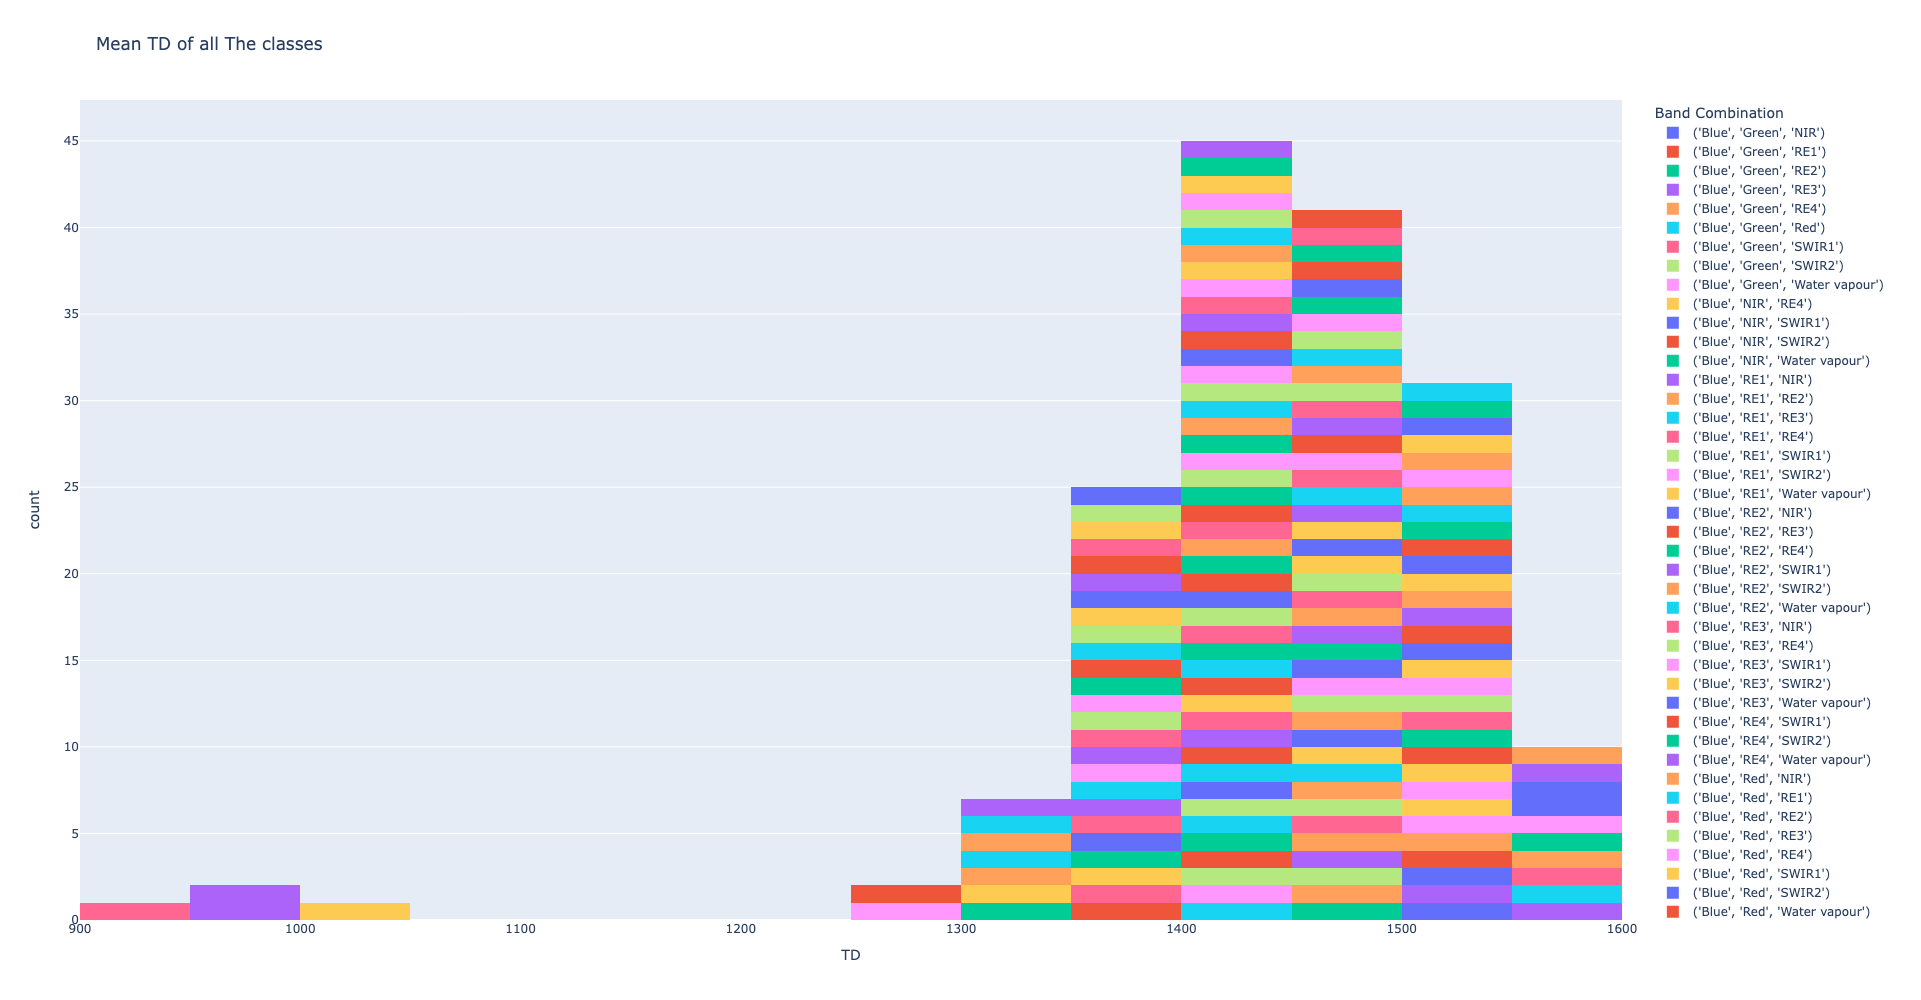

In [573]:
fig = px.histogram(final_df_g,x='TD',color='Band Combination',height=1000,title='Mean TD of all The classes')
fig.write_html("../Arecanut/mean_td_all_class.html")
fig.show()

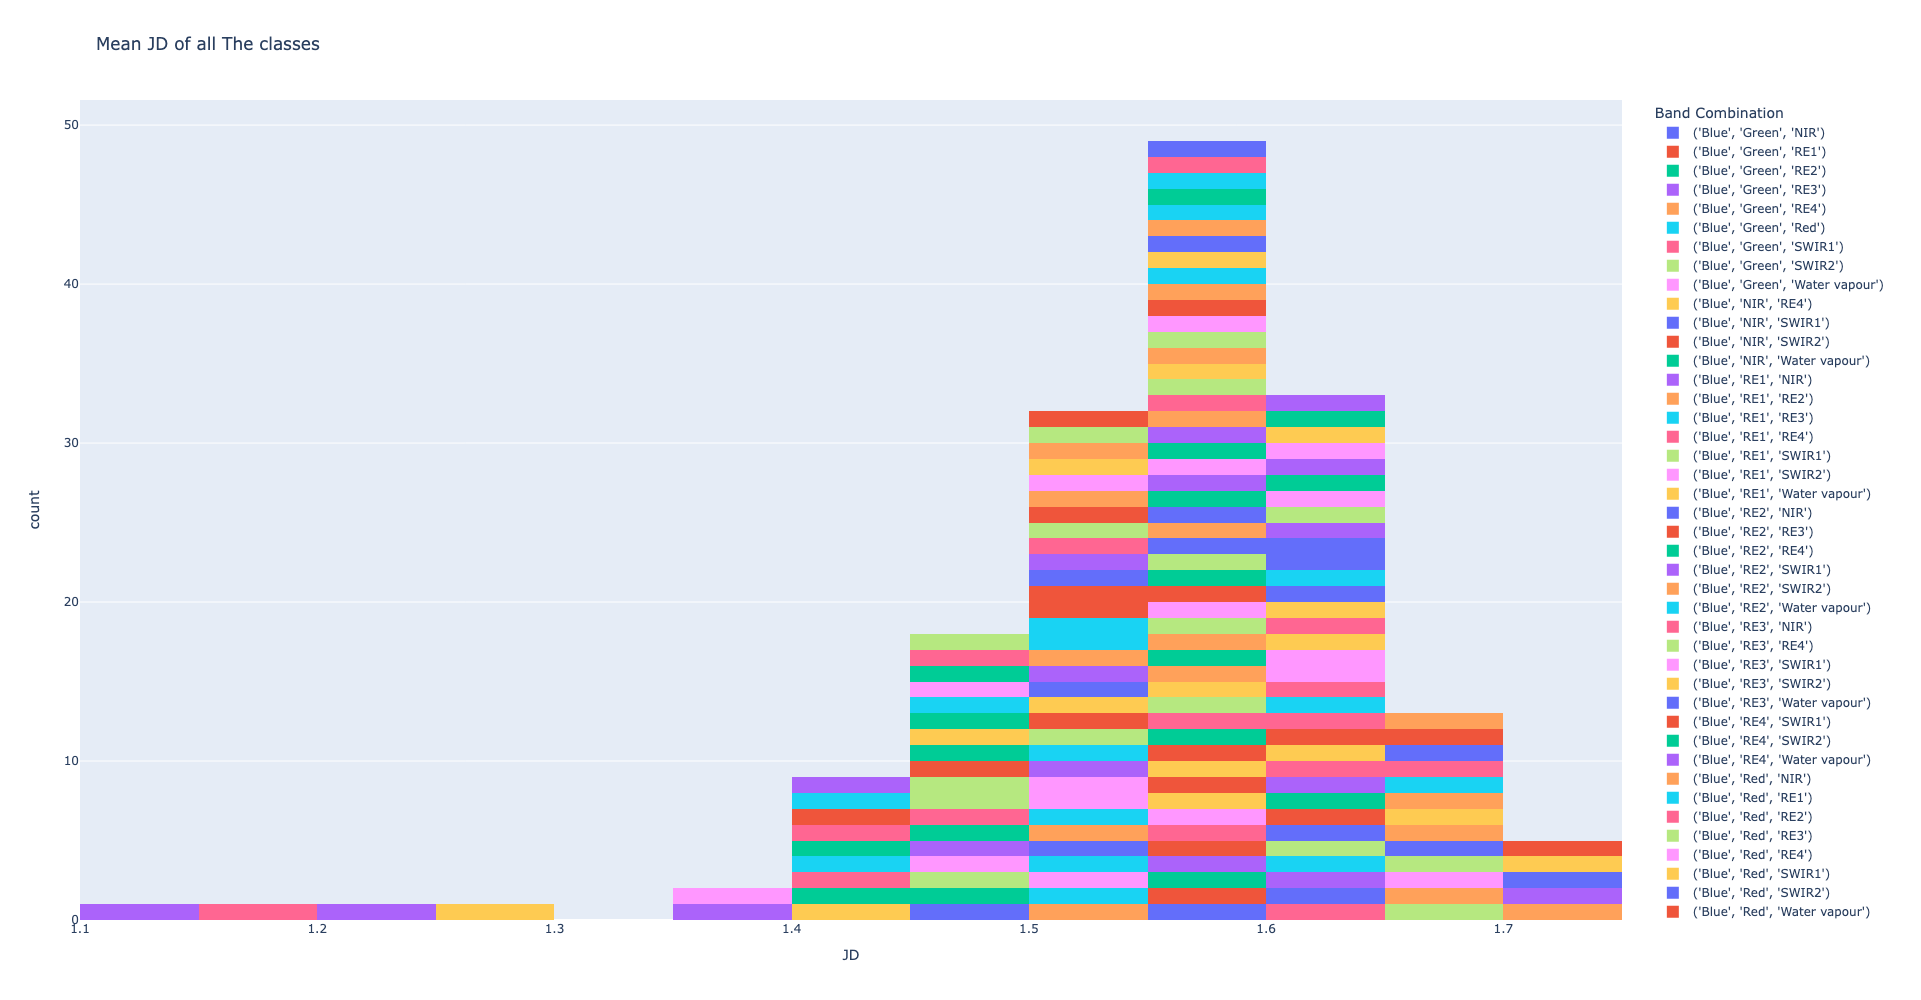

In [570]:
px.histogram(final_df_g,x='JD',color='Band Combination',height=1000,title='Mean JD of all The classes')